# **強化學習專案：Q-learning問題 :利用 RL 逃離迷宮

### **說明：**
此專案基於強化學習的 Q-learning 算法。系統通過與環境互動，從回饋中學習，逐步改進決策，最終找到最佳行動策略。

### **使用方法：Q-learning**

理論：Q-learning 是一種強化學習算法，它依賴於“獎勵和懲罰”機制。通過對環境的探索，系統會更新其行動價值（Q值），並逐漸學會在每個狀態下選擇使總回報最大的行動。Q-learning 的理論基礎是馬爾可夫決策過程（Markov Decision Process），它基於過去的經驗來估計未來的行為回報。


迷宮本身為 21 * 11 的迷宮

起點左上角 (0,0) 終點為右下角 (20,10)

X 表示牆壁位置(顏色為綠色方便區分)
O 表示寶藏位置(顏色為橘色方便區分)
S 表示起點位置
G 表示終點位置
黃色底色表示可能路徑

牆壁

陣列位置：

(0,4),(0,5),(0,7),(0,9),(1,1),(1,2),(1,4),(1,9),(1,10),(1,14),(1,18),(2,1),(2,3),(2,5),(2,7),(2,8),(2,9),(2,11),(2,13),(2,15),(2,16),(2,17),(2,19),(3,2),(3,8),(3,11),(3,17),(4,1),(4,4),(4,6),(4,10),(4,13),(4,16),(4,17),(4,18),(4,20),(5,4),(5,5),(5,6),(5,8),(5,9),(5,14),(5,15),(6,1),(6,2),(6,3),(6,6),(6,8),(6,10),(6,15),(6,16),(6,17),(6,19),(7,4),(7,6),(7,8),(7,10),(7,11),(7,17),(7,19),(8,1),(8,4),(8,8),(8,10),(8,13),(8,15),(8,18),(8,19),(9,1),(9,2),(9,4),(9,6),(9,7),(9,17),(10,1),(10,4),(10,16),(10,19)

數值： 4,5,7,9,22,23,25,30,31,35,39,43,45,47,49,50,51,53,55,57,58,59,61,65,71,74,80,85,88,90,94,97,100,101,102,104,109,110,111,113,114,119,120,127,128,129,132,134,136,141,142,143,145,151,153,155,157,158,164,166,169,172,176,178,181,183,186,187,190,191,193,195,196,206,211,214,226,229

起點

陣列位置 （0, 0)

數值 0

終點

陣列位置 (20, 10)

數值 230

寶藏

陣列位置 （0, 6),(3, 16),(8, 2),(10, 2),(10, 17)

數值 6, 79, 170, 212, 227

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 300)

設定 x, y 軸長度，
範例為 40 * 30 的無障礙迷宮
並設定可行動動作為上下左右

目標位置在最右下角
以及各項參數設定
SCORE 為計算寶藏分數用

In [2]:
N_STATES_x = 21
N_STATES_y = 11
ACTIONS = ["left", "right", "up", "down"]
action_probabilities = [0.3, 0.2, 0.2, 0.3]
GOAL = 230

#探索率 - 使否要利用已知的訊息，降低可以更多利用已知 原始:0.9
EPSILON = 0.9
EPSILON_MIN = 0.25
EPSILON_DECAY = 0.005
START_DECAY = 300

#學習率 - 新資訊對於就資訊的影響程度，增高可以使新資訊更容易被考慮 原始:0.1
ALPHA = 0.1
#衰減因子，用於控制未來獎勵的重要性。具體來說，Gamma決定了我們對未來獎勵的折價程度。 越大代表越想要未來
GAMMA = 0.9

# 每回合最大步數、最多試幾次、分數
MAX_STEPS = 1000
MAX_EPISODES = 1000
FRESH_TIME = 0
SCORE = 0

# 牆壁、寶藏、最佳路線
walls = [4,5,7,9,22,23,25,30,31,35,39,43,45,47,49,50,51,53,55,57,58,59,61,65,71,74,80,85,88,90,94,97,100,101,102,104,109,110,111,113,114,119,120,127,128,129,132,134,136,141,142,143,145,151,153,155,157,158,164,166,169,172,176,178,181,183,186,187,190,191,193,195,196,206,211,214,226,229]
treasures = [6, 79, 170, 212, 227]
success_path = [21, 42, 63, 84, 105, 106, 107,108, 87, 66, 67, 68, 69, 70,91, 112, 133, 154, 175, 174,
        173, 194, 215, 216, 217, 218,219, 220, 221, 222, 201, 180,
        159, 138, 117, 96, 75, 54, 33,12, 13, 14, 15, 16, 17, 18, 19,
        20, 41, 62, 83, 82, 103, 124,125, 146, 167, 188, 209]


#額外紀錄
STEP_MIN = MAX_STEPS #紀錄最小步數
SCORE_MAX = -1 #紀錄找到最多寶箱
BEST1 = {} #紀錄最小步數該次資訊
BEST2 = {} #紀錄最多寶藏該次資訊

treasure_v=[]
path_v = []
visited = None


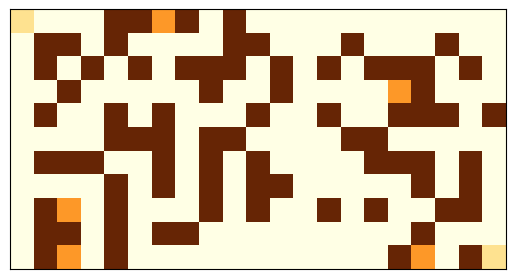

In [8]:
import matplotlib.pyplot as plt

def create_maze():
    maze = np.ones((11, 21))  # 创建一个21x11的迷宫，初始值为1

    walls = [(0,4),(0,5),(0,7),(0,9),(1,1),(1,2),(1,4),(1,9),(1,10),(1,14),(1,18),(2,1),(2,3),(2,5),(2,7),(2,8),(2,9),(2,11),(2,13),(2,15),(2,16),(2,17),(2,19),(3,2),(3,8),(3,11),(3,17),(4,1),(4,4),(4,6),(4,10),(4,13),(4,16),(4,17),(4,18),(4,20),(5,4),(5,5),(5,6),(5,8),(5,9),(5,14),(5,15),(6,1),(6,2),(6,3),(6,6),(6,8),(6,10),(6,15),(6,16),(6,17),(6,19),(7,4),(7,6),(7,8),(7,10),(7,11),(7,17),(7,19),(8,1),(8,4),(8,8),(8,10),(8,13),(8,15),(8,18),(8,19),(9,1),(9,2),(9,4),(9,6),(9,7),(9,17),(10,1),(10,4),(10,16),(10,19)]
    treasures = [(0,6),(3,16),(8,2),(10,2),(10,17)]

    # 设置墙壁的值为0
    for wall in walls:
        maze[wall[0], wall[1]] = 5

    # 设置宝藏的值为2
    for treasure in treasures:
        maze[treasure[0], treasure[1]] = 3
    maze[0,0] = 2
    maze[10,20] = 2

    return maze

maze = create_maze()
plt.imshow(maze, cmap='YlOrBr')
plt.xticks([])
plt.yticks([])
plt.show()


Q-table

In [9]:
# x : 21 y :11
def build_q_table(N_STATES_x, N_STATES_y, actions):
    table = pd.DataFrame(
        np.zeros((N_STATES_x * N_STATES_y, len(actions))),
        columns=actions,
    )
    return table

In [10]:
 # S: 當前位置
 # 假設隨機數 > epsilon 選擇隨機動作、否則進行當前位置可獲的最大值的動作
 # 或是根本還沒被探索過
 # 使用.idxmax找到最大值的動作
def choose_action(state, q_table, step, path):
    state_actions = q_table.iloc[state, :]
    if (np.random.uniform() > EPSILON) or ((state_actions == 0).all()):
        action_name = np.random.choice(ACTIONS, p=action_probabilities)
    else:
        action_name = state_actions.idxmax()
    return action_name

In [11]:
# 根據 狀態S和動作A來返回下一個狀態的S_和對應的獎勵R
def get_env_feedback(S, A, path):
    if A == "right":
        if S + 1 == GOAL:
            S_ = "terminal"
            R = 100
        #超出 從0開始，20表示在最後一欄
        elif S % N_STATES_x == N_STATES_x - 1:
            S_ = S
            R = -100
        # 是牆壁
        elif any(x == S + 1 for x in walls):
            S_ = S
            R = -100
        # 找到寶物
        elif any(x == S + 1 for x in treasures) and not any(x == S + 1 for x in treasure_v):
            S_ = S + 1
            R = 80
        #走到完美路徑
        #elif any(x == S +1 for x in success_path):
        #  S_ = S +1
        #  R = 10
        #新的路線
        elif not any(x == S + 1 for x in path_v):
        #elif S+1 not in path:
          S_ = S + 1
          R = 5
        else:
          S_ = S + 1
          R = 0
    # todo

    # 往上走
    elif A =="up":

        # 終點
        if S - N_STATES_x == GOAL:
          S_ = "terminal"
          R = 100
        # 還在第一列，因為第一列是0~20
        elif S < N_STATES_x:
          S_ = S
          R = -100
        # 往上面一列是牆壁
        #elif S - N_STATES_x in walls:
        elif any(x == S - N_STATES_x for x in walls):
          S_ = S
          R = -100
        # 找到寶物
        elif any(x == S - N_STATES_x for x in treasures) and not any(x == S - N_STATES_x for x in treasure_v):
          S_ = S - N_STATES_x
          R = 80
        #走到完美路徑
        #elif any(x == S - N_STATES_x for x in success_path):
        #  S_ = S - N_STATES_x
        #  R = 10
        # 新路徑
        #elif S - N_STATES_x not in path_v:
        elif not any(x == S - N_STATES_x for x in path_v):
          S_ = S - N_STATES_x
          R = 5
        # 往上面一列
        else:
          S_ = S - N_STATES_x
          R = 0
    # 往下走
    elif A == "down":
        # 終點
        if S + N_STATES_x == GOAL:
            S_ = "terminal"
            R = 100
        # 已經在最後一列
        elif S + N_STATES_x > GOAL:
          S_ = S
          R = -100
        # 往下面一列是牆壁
        elif any(x == S + N_STATES_x for x in walls):
          S_ = S
          R = -100
        # 找到寶物
        elif any(x == S + N_STATES_x for x in treasures) and not any(x == S + N_STATES_x for x in treasure_v):
          S_ = S + N_STATES_x
          R = 80
        #走到完美路徑
        #elif any(x == S + N_STATES_x for x in success_path):
        #  S_ = S + N_STATES_x
        #  R = 10
        # 新路徑
        elif S + N_STATES_x not in path_v:
          S_ = S + N_STATES_x
          R = 5
        # 往下面一列
        else:
          S_ = S + N_STATES_x
          R = 0
    # 往左走不可能抵達終點
    elif A == "left":
        # 終點
        if S - 1 == GOAL:
          S_ = "terminal"
          R = 100
        # 超出 還在第一欄
        elif S % N_STATES_x == 0:
          S_ =S
          R = -100
        # 是牆壁
        elif any(x == S -1 for x in walls):
            S_ = S
            R = -100
        # 找到寶物
        elif any(x == S - 1 for x in treasures) and not any(x == S - 1 for x in treasure_v):
            S_ = S-1
            R = 80
        #走到完美路徑
        #elif any(x == S -1 for x in success_path):
        #  S_ = S -1
        #  R = 10
        # 新路徑
        elif S-1 not in path_v:
          S_ = S - 1
          R = 5
        else:
            S_ = S - 1
            R = 0

    return S_, R

In [12]:
def print_env(env_map):
    for row in env_map:
        print(" ".join(row))

In [13]:
def update_env(S, episode, step_counter):
    treasure_collected = set()
    env_map = [["-" for i in range(N_STATES_x)] for j in range(N_STATES_y)]
    # 將牆壁位置設置為 "+"
    for wall in walls:
        env_map[wall // N_STATES_x][wall % N_STATES_x] = "+"
    for treasure in treasures:
        env_map[treasure // N_STATES_x][treasure % N_STATES_x] = "*"
    env_map[int(GOAL / N_STATES_x)][GOAL % N_STATES_x] = "T"
    result = []
    if S == "terminal":
        interaction = "Episode %s: total_steps=%s, 寶箱=%s" % (episode + 1, step_counter, treasure_v)

        global STEP_MIN, SCORE_MAX, BEST1, BEST2
        # 最佳路徑資訊
        if step_counter < STEP_MIN:
            STEP_MIN = step_counter
            BEST1['Episode'] = episode + 1
            BEST1['total_steps'] = step_counter
            BEST1['Score'] = SCORE
        elif step_counter == STEP_MIN:
            if 'Episode' in BEST1:
                if SCORE > BEST1['Score']:
                    BEST1['Episode'] = episode + 1
                    BEST1['total_steps'] = step_counter
                    BEST1['Score'] = SCORE
        # 最佳分數
        if SCORE > SCORE_MAX:
            SCORE_MAX = SCORE
            BEST2['Episode'] = episode + 1
            BEST2['total_steps'] = step_counter
            BEST2['Score'] = SCORE
        elif SCORE == SCORE_MAX:
            if 'Episode' in BEST2:
                if step_counter < BEST2['total_steps']:
                    BEST2['Episode'] = episode + 1
                    BEST2['total_steps'] = step_counter
                    BEST2['Score'] = SCORE

        result.append(interaction)
        print(" --------------------- " + "成功走出" + " ---------------------")
        print('找到寶藏 '+ str(treasure_v))
        print('目前次數 '+ str(episode))
        print('目前探索率 '+ str(EPSILON))
        print('步數：'+ str(step_counter))
        print("\r", end="")
        print('\n')
        return True
    else:
        env_map[int(S / N_STATES_x)][int(S % N_STATES_x)] = "o"
        #print_env(env_map)
        time.sleep(FRESH_TIME)
        return False
#計算寶箱分數
def count_score(S):
    if S in treasures and S not in treasure_v:
        global SCORE
        treasure_v.append(S)
        SCORE = SCORE + 1

In [14]:

def update_epsilon():
    global EPSILON
    EPSILON *= 0.9
    if EPSILON < EPSILON_MIN:
        EPSILON = EPSILON_MIN


def rl():
    q_table = build_q_table(N_STATES_x, N_STATES_y, ACTIONS)
    for episode in range(MAX_EPISODES):
        print("----------------"+ " 第 " + str(episode+1) + " 次 " + "----------------")

        #分數
        global SCORE
        SCORE = 0  # 重置計分
        #寶藏路徑
        global treasure_v
        treasure_v = []
        #路徑
        global path_v
        path_v = []
        #步數
        step_counter = 0
        #起點
        S = 0
        is_terminated = False
        path = []

        if update_env(S, episode, step_counter):
            print("成功")
        while not is_terminated and step_counter < MAX_STEPS:
            # 選擇下一個動作
            A = choose_action(S, q_table, step_counter,path)
            # 紀錄動作
            path.append(S)
            # 根據挑選動作，返回下一個動作的reward
            S_, R = get_env_feedback(S, A, path)

            # 記錄這一次路徑
            visited = S_
            if S_ not in path_v:
              path_v.append(S_)
            count_score(S_)

            q_predict = q_table.loc[S, A]
            # 判斷是否結束
            if S_ != "terminal":
                q_target = R + GAMMA * q_table.iloc[S_, :].max()
            else:
                q_target = R
                is_terminated = True
            q_table.loc[S, A] += ALPHA * (q_target - q_predict)
            S = S_
            #print("----------------"+"   episode:  "+str(episode)+"   steps:  "+str(step_counter)+" ---------------------")
            #print("----------------"+" 1. action: "+A+" 2. score: "+ str(SCORE) +" ---------------------")
            #update_env(S, episode, step_counter + 1)
            update_env(S, episode, step_counter + 1)
            step_counter += 1
        if not is_terminated:
          print( "---------------- "+ '失敗'+" ---------------------")
          print('找到寶藏 '+ str(treasure_v))
          print('目前探索率 '+ str(EPSILON))
          print('最後位置：'+ str(S))

        if episode > START_DECAY :
          if not episode %30:
            update_epsilon()

            #if update_env(S, episode, step_counter + 1):
            #  interaction = "Episode %s: total_steps=%s" % (episode + 1, step_counter)
            #  Result.append(interaction)
            #step_counter += 1
    return all, q_table

In [15]:
if __name__ == "__main__":
    EPSILON = 0.9
    q_table = rl()
    print("\r\nQ-table:\n")
    print(q_table)
    print('最多寶箱', BEST2)

串流輸出內容已截斷至最後 5000 行。


---------------- 第 399 次 ----------------
 --------------------- 成功走出 ---------------------
找到寶藏 []
目前次數 398
目前探索率 0.6561000000000001
步數：99


---------------- 第 400 次 ----------------
 --------------------- 成功走出 ---------------------
找到寶藏 []
目前次數 399
目前探索率 0.6561000000000001
步數：131


---------------- 第 401 次 ----------------
 --------------------- 成功走出 ---------------------
找到寶藏 []
目前次數 400
目前探索率 0.6561000000000001
步數：97


---------------- 第 402 次 ----------------
 --------------------- 成功走出 ---------------------
找到寶藏 []
目前次數 401
目前探索率 0.6561000000000001
步數：102


---------------- 第 403 次 ----------------
 --------------------- 成功走出 ---------------------
找到寶藏 []
目前次數 402
目前探索率 0.6561000000000001
步數：92


---------------- 第 404 次 ----------------
 --------------------- 成功走出 ---------------------
找到寶藏 []
目前次數 403
目前探索率 0.6561000000000001
步數：121


---------------- 第 405 次 ----------------
 --------------------- 成功走出 ---------------------
找到寶藏 []
目前次數 404
目前探索率 0.65610